In [1]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import seaborn as sns
import random
import os
import gc

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models, Sequential
from tensorflow.keras import optimizers

from keras.layers.core import Dense, Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D, SeparableConv2D

from tensorflow.keras.applications.vgg16 import VGG16

from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import img_to_array, load_img

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd /content/drive/MyDrive/

/content/drive/MyDrive


In [4]:
# Creating file path for our train data and test data
dir = r'/content/drive/MyDrive'
train_dir=os.path.join(dir,'train')
test_dir=os.path.join(dir,'test')
val_dir=os.path.join(dir,'valid')

# os.listdir returns a list containing all files under the given path
print(f"There are {len(os.listdir(train_dir))} images in train.")
print(f"There are {len(os.listdir(test_dir))} images in test.")

There are 2540 images in train.
There are 234 images in test.


In [5]:
# Getting 'Autistic' and 'Non-Autistic' train images from respective file names of train data
train_non_autistic = []
train_autistic = []
for i in os.listdir(train_dir):
    if 'Non_Autistic' in ("../content/drive/MyDrive/train/{}".format(i)):
        train_non_autistic.append(("/content/drive/MyDrive/train/{}".format(i)))
    else:
        train_autistic.append(("/content/drive/MyDrive/train/{}".format(i)))
        
# Getting test images from test data file path
test_imgs = ["/content/drive/MyDrive/test/{}".format(i) for i in os.listdir(test_dir)]


# Concatenate 'Autistic'  and 'Non-Autistic' images and shuffle them as train_images
train_imgs = train_autistic + train_non_autistic
random.shuffle(train_imgs)

# Remove the lists to save space
del train_autistic
del train_non_autistic
gc.collect()

356

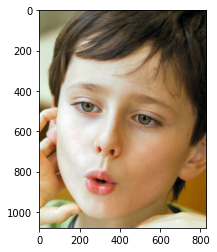

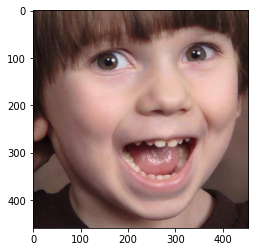

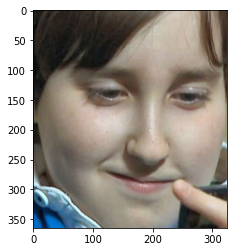

In [6]:
# Plot first 3 images from train_imgs
import matplotlib.image as mpimg
for ima in train_imgs[0:3]:
    img=mpimg.imread(ima)
    imgplot = plt.imshow(img)
    plt.show()

In [7]:
# Set the dimensions for images
nrows = 150
ncolumns  = 150
channels = 3

# Read and process the images: Function returns X,y. X - list of resized images, y - list of labels for the images

def read_and_process_image(list_of_images):
    X = []
    y = []
    
    for image in list_of_images:
        X.append(cv2.resize(cv2.imread(image, cv2.IMREAD_COLOR), (nrows, ncolumns), interpolation = cv2.INTER_CUBIC))
        if 'Non_Autistic' in image:
            y.append(0)
        else:
            y.append(1)
            
    return X,y

In [8]:
# Get resized images and labels from train data
X_train, y_train = read_and_process_image(train_imgs)

# Delete train images to save space
del train_imgs
gc.collect()

4854

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Train image labels')

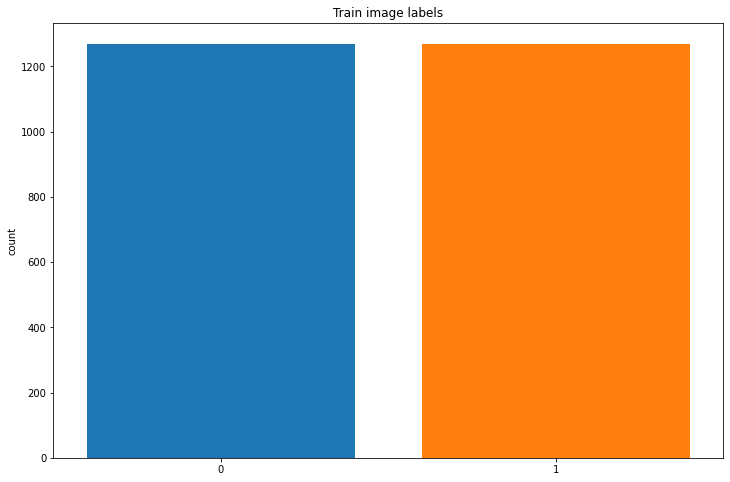

In [9]:
# Convert the lists to array
plt.figure(figsize=(12, 8))
X_train = np.array(X_train)
y_train = np.array(y_train)
sns.countplot(y_train, saturation=1)
plt.title("Train image labels")

In [10]:
# Shape of train images and labels
print("Shape of train images:", X_train.shape)
print("Shape of train labels:", y_train.shape)

Shape of train images: (2540, 150, 150, 3)
Shape of train labels: (2540,)


In [11]:
# Repeat the above process for validation data to get val_images
val_autistic = "/content/drive/MyDrive/valid/Autistic"
val_non_autistic = "/content/drive/MyDrive/valid/Non_Autistic"
val_autistic_imgs = ["/content/drive/MyDrive/valid/Autistic/{}".format(i) for i in os.listdir(val_autistic)]
val_non_autistic_imgs = ["/content/drive/MyDrive/valid/Non_Autistic/{}".format(i) for i in os.listdir(val_non_autistic)]
val_imgs = val_autistic_imgs + val_non_autistic_imgs
random.shuffle(val_imgs)

# Remove the lists to save space
del val_autistic_imgs
del val_non_autistic_imgs
gc.collect()

219

In [12]:
# Get resized images and labels from validation data
X_val, y_val = read_and_process_image(val_imgs)

# Delete validation images to save space
del val_imgs
gc.collect()

88

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Validation image labels')

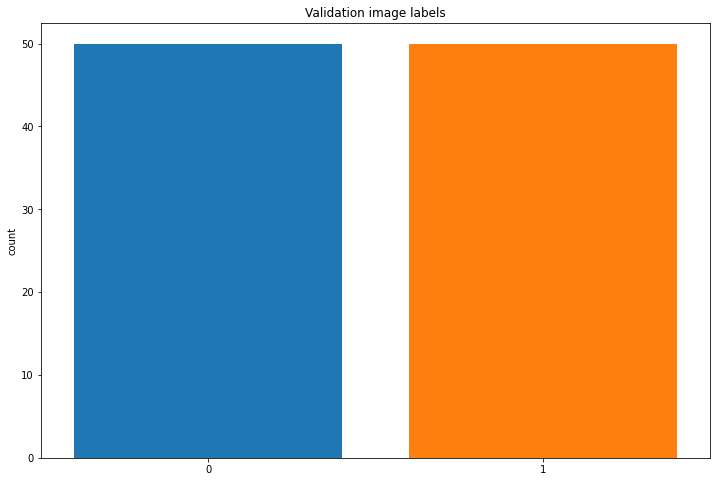

In [13]:
# Convert the lists to array
plt.figure(figsize=(12, 8))
X_val = np.array(X_val)
y_val = np.array(y_val)
sns.countplot(y_val, saturation=1)
plt.title("Validation image labels")

In [14]:
# Shape of validation images and labels
print("Shape of validation images:", X_val.shape)
print("Shape of validation labels:", y_val.shape)

Shape of validation images: (100, 150, 150, 3)
Shape of validation labels: (100,)


In [15]:
# Get length of train data and validation data
ntrain = len(X_train)
nval = len(X_val)
batch_size = 32

In [16]:
# Calling pre-trained VGG16 model
base_model = VGG16(include_top=False,weights='imagenet',input_shape=(150,150,3))

58900480/58889256 [==============================] - 0s 0us/step


In [17]:
# Freeze the layers in pre-trained model, we don't need to train again
for layer in base_model.layers:
   layer.trainable = False

In [18]:
# Let's see how many layers are in the vgg model
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  19


In [19]:
# Create our classifier model, connect pre-trained model vgg to our model
model = keras.models.Sequential()
model.add(base_model)
model.add(layers.Conv2D(512,(3,3),activation = "relu", input_shape=(150,150,3)))
model.add(layers.MaxPool2D(2,2))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation = 'relu'))
model.add(layers.Dropout(0.7))
model.add(layers.Dense(1, activation = 'sigmoid'))


In [20]:
# Create summary of our model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 conv2d (Conv2D)             (None, 2, 2, 512)         2359808   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 1, 1, 512)        0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 512)               262656    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                        

In [21]:
# Compile the model specifying optimizer, loss function and metrics
model.compile(loss = 'binary_crossentropy', optimizer = keras.optimizers.Adam(), metrics = ['acc'])

In [22]:
# Configure data augumentation and scaling of images to prevent overfitting since we have a small train data
train_datagen = ImageDataGenerator(rescale = 1./255,
                                  rotation_range = 45,
                                  width_shift_range = 0.1,
                                  height_shift_range = 0.1,
                                  shear_range = 0.1,
                                  zoom_range = 0.1,
                                  horizontal_flip = True)

# Only rescaling for validation data
val_datagen = ImageDataGenerator(rescale = 1./255)

In [23]:
# Create test and validation image generator
train_generator = train_datagen.flow(X_train, y_train, batch_size = batch_size)
val_generator = val_datagen.flow(X_val, y_val, batch_size = batch_size)

In [24]:
# Train the model
history = model.fit(train_generator,
                              steps_per_epoch=ntrain // batch_size,
                              epochs=50,
                              validation_data=val_generator,
                              validation_steps=nval // batch_size
                             )

Epoch 1/50
79/79 [==============================] - 439s 6s/step - loss: 0.6819 - acc: 0.6439 - val_loss: 0.5558 - val_acc: 0.7188
Epoch 2/50
79/79 [==============================] - 433s 5s/step - loss: 0.5299 - acc: 0.7400 - val_loss: 0.5001 - val_acc: 0.7917
Epoch 3/50
79/79 [==============================] - 434s 5s/step - loss: 0.5070 - acc: 0.7428 - val_loss: 0.5296 - val_acc: 0.7396
Epoch 4/50
79/79 [==============================] - 441s 6s/step - loss: 0.4857 - acc: 0.7656 - val_loss: 0.5301 - val_acc: 0.7292
Epoch 5/50
79/79 [==============================] - 438s 6s/step - loss: 0.4748 - acc: 0.7727 - val_loss: 0.5420 - val_acc: 0.6979
Epoch 6/50
79/79 [==============================] - 444s 6s/step - loss: 0.4621 - acc: 0.7683 - val_loss: 0.5546 - val_acc: 0.6875
Epoch 7/50
79/79 [==============================] - 446s 6s/step - loss: 0.4506 - acc: 0.7839 - val_loss: 0.5818 - val_acc: 0.6979
Epoch 8/50
79/79 [==============================] - 454s 6s/step - loss: 0.4470 - a

In [25]:
# Learning curves for training and validation
history_df = pd.DataFrame(history.history)
history_df

,loss,acc,val_loss,val_acc
0,0.681913,0.643939,0.555813,0.718750
1,0.529948,0.740032,0.500084,0.791667
2,0.506980,0.742823,0.529585,0.739583
3,0.485719,0.765550,0.530111,0.729167
4,0.474762,0.772727,0.542022,0.697917
5,0.462080,0.768341,0.554618,0.687500
6,0.450613,0.783892,0.581788,0.697917
7,0.447023,0.780702,0.553151,0.729167
8,0.438692,0.793062,0.528282,0.770833
9,0.437145,0.796651,0.541771,0.760417


Text(0.5, 1.0, 'Training and Validation Accuracy')

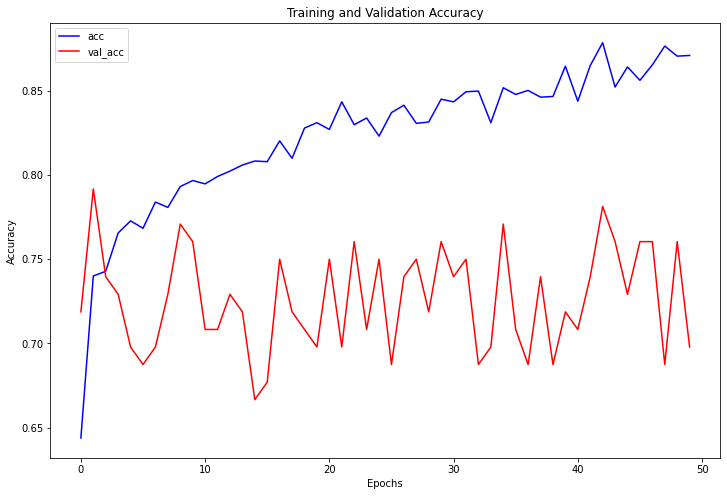

In [26]:
# Plot train and validation accuracy
plt.figure(figsize=(12, 8))
sns.lineplot(data=history_df.loc[:, ["acc", "val_acc"]], palette=['b', 'r'], dashes=False)
sns.set_style("whitegrid")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")

Text(0.5, 1.0, 'Training and Validation Loss')

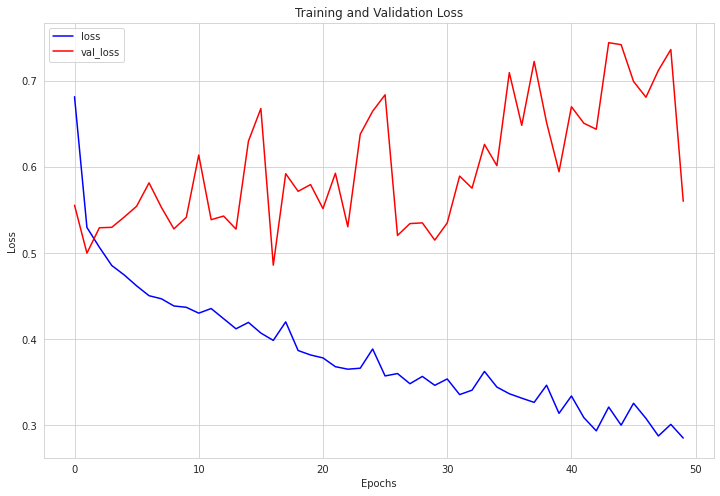

In [27]:
# Plot train and validation loss
plt.figure(figsize=(12, 8))
sns.lineplot(data=history_df.loc[:, ["loss", "val_loss"]], palette=['b', 'r'], dashes=False)
sns.set_style("whitegrid")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")

In [28]:
# Read and resize test images
random.shuffle(test_imgs)
X_test, y_test = read_and_process_image(test_imgs)
X = np.array(X_test)
#test_datagen = ImageDataGenerator(rescale = 1./255)

In [29]:
# Predict label for test images
pred = model.predict(X)
threshold = 0.5
predictions = np.where(pred > threshold, 1,0)
#print(predictions)

In [30]:
# Plot test images and their corresponding predictions
test = pd.DataFrame(data = predictions, columns = ["predictions"])
test
test["filename"] = [os.path.basename(i) for i in test_imgs]
test["test_labels"] = y_test
test = test[["filename", "test_labels", "predictions"]]
test

,filename,test_labels,predictions
0,Non_Autistic.76.jpg,0,0
1,Non_Autistic.131.jpg,0,0
2,Non_Autistic.13.jpg,0,0
3,Non_Autistic.43.jpg,0,0
4,Non_Autistic.70.jpg,0,0
...,...,...,...
229,Non_Autistic.69.jpg,0,0
230,Non_Autistic.127.jpg,0,0
231,Autistic.30.jpg,1,0
232,Autistic.69.jpg,1,1


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


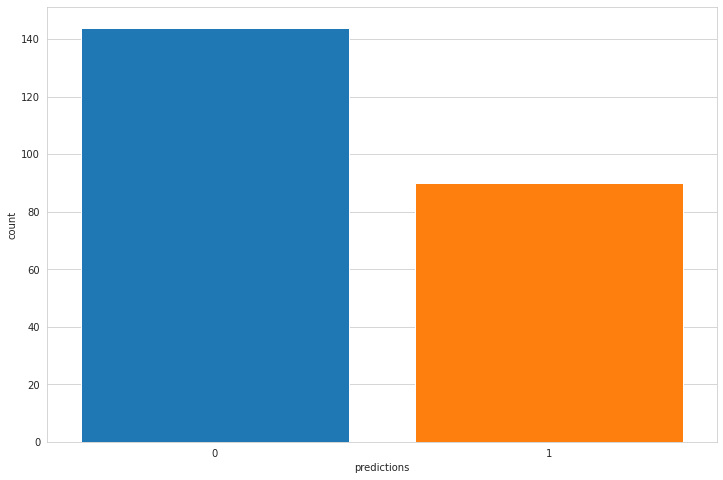

In [31]:
# Plotting the predictied label count in each class
plt.figure(figsize=(12, 8))
sns.countplot(test["predictions"], saturation=1)

In [32]:
model_accuracy = accuracy_score(y_test, predictions)
print("Model Accuracy: {:.2f}%".format(model_accuracy * 100))

Model Accuracy: 75.64%


In [33]:
# Generating Classification report for model's performance in each class
cl_report = classification_report(y_test, predictions)
print(cl_report)

              precision    recall  f1-score   support

           0       0.78      0.81      0.80       139
           1       0.71      0.67      0.69        95

    accuracy                           0.76       234
   macro avg       0.75      0.74      0.75       234
weighted avg       0.75      0.76      0.76       234



In [34]:
# Generating Confusion Matrix for the predictions against true labels
cn_matrix= confusion_matrix(y_test, predictions)
cn_matrix

array([[113,  26],
       [ 31,  64]])

Text(0.5, 1.0, 'Confusion Matrix')

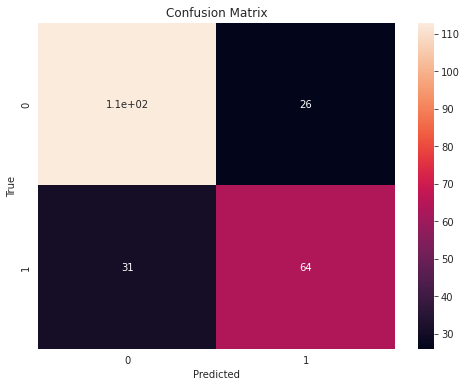

In [35]:
# Plotting the True Positives, True Negatives, False Positives and False Negatives from model's predictions
f, ax = plt.subplots(figsize = (8,6))
ax = sns.heatmap(cn_matrix, annot=True)
ax.set_xlabel("Predicted")
ax.set_ylabel("True")
ax.set_title("Confusion Matrix")

In [36]:
# Let's plot the AUC-ROC curve to assess the performance of our model
fpr, tpr, _ = roc_curve(y_test, predictions)
roc_auc= auc(fpr, tpr)

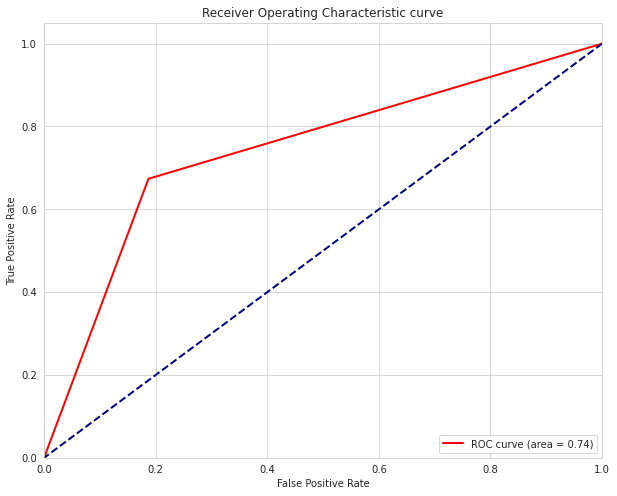

In [37]:
plt.figure(figsize = (10,8))
plt.plot(fpr, tpr, color = 'red', lw = 2, label = 'ROC curve (area = %0.2f)' % roc_auc)
plt.plot([1,0], [1,0], color = 'navy', lw = 2, linestyle = '--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("Receiver Operating Characteristic curve")
plt.legend(loc = 'lower right')

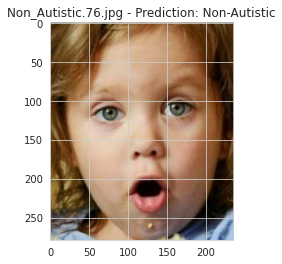

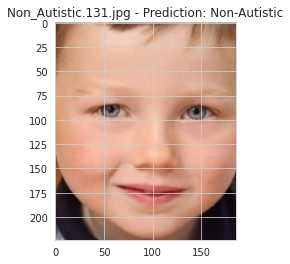

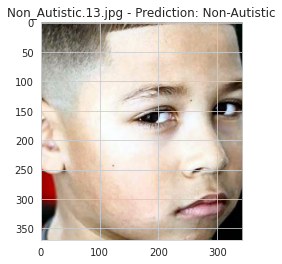

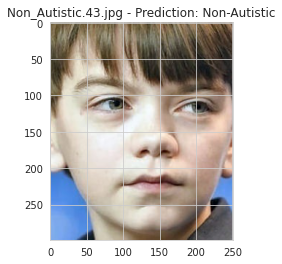

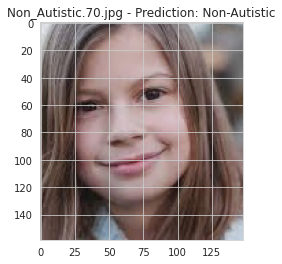

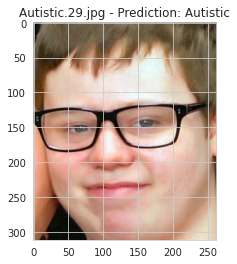

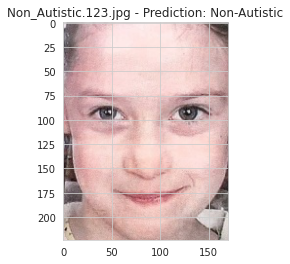

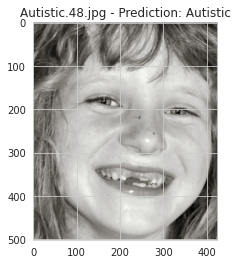

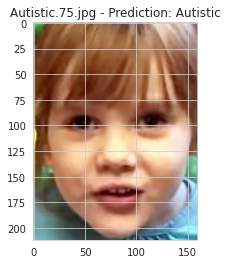

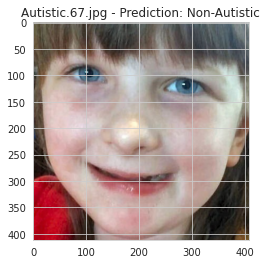

In [38]:
# Let's check our predcitions against some test images
plt.figure(figsize=(4,4))
for val, i in enumerate(test_imgs[:10]):
    img = mpimg.imread(i)
    imgplot = plt.imshow(img)
    plt.title(os.path.basename(i) + ' - Prediction: ' +  f"{'Autistic' if predictions[val] == 1 else 'Non-Autistic'}")
    plt.show()

In [39]:
model.save_weights('weights_model.h5')

In [40]:
model.save('my_model.h5')

In [43]:
def download_history():
  import pickle
  from google.colab import files

  with open('model_history.pkl', 'wb') as f:
    pickle.dump(history.history, f)

  files.download('model_history.pkl')

download_history()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>